# Social Doors Cerebellum PPI Analysis

Author: Haroon Popal 

Code borrowed from [dartbrains](https://dartbrains.org/content/Connectivity.html#psychophysiological-interactions)

## Set Up

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltools.data import Brain_Data, Design_Matrix, Adjacency
from nltools.mask import expand_mask
from nltools.stats import fdr, threshold, fisher_r_to_z, one_sample_permutation, zscore
from sklearn.metrics import pairwise_distances
from nilearn.plotting import plot_glass_brain, plot_stat_map

#from bids import BIDSLayout, BIDSValidator

### Set Paths

In [2]:
bids_dir = '/data/projects/social_doors/'
os.chdir(bids_dir)

outp_dir = os.path.join(bids_dir, 'derivatives', 'ppi_analysis')
data_dir = os.path.join(bids_dir, 'derivatives','social_doors-nilearn')

if os.path.exists(outp_dir):
    print('Output directory already exists. Continuing will overwrite data.')
else:
    os.makedirs(outp_dir)
    

#layout = BIDSLayout(bids_dir, derivatives=True)

FileNotFoundError: [Errno 2] No such file or directory: '/data/projects/social_doors/'

### Import participant list

In [3]:
subjs_scan_info = pd.read_csv(bids_dir+'derivatives/participants_good.tsv', sep='\t')

subjs_list = list(subjs_scan_info['participant_id'].unique())
len(subjs_list)

subjs_list.sort()
print('Found '+str(len(subjs_list))+' subjects')
subj = subjs_list[0]

Found 63 subjects


In [4]:
subjs_scan_info

,Unnamed: 0,participant_id,age,sex,group
0,0,sub-010,13,F,kid
1,2,sub-013,13,M,kid
2,5,sub-028,15,M,kid
3,6,sub-036,16,F,kid
4,7,sub-5049,12,F,kid
...,...,...,...,...,...
58,76,sub-4069,22,F,college
59,77,sub-6003,23,M,college
60,78,sub-6004,19,M,college
61,79,sub-6005,21,F,college


### Import MRI quality control info

In [5]:
qc_summary = pd.read_csv('derivatives/qc_summary.csv')

# Filter qc summary for only good participants
qc_summary_good = qc_summary[qc_summary['subject'].isin(subjs_list)]
qc_summary_good.head()

,subject,run,rating,artifacts
0,sub-010,mdoors_run-1,4,[]
1,sub-010,mdoors_run-2,3,['head-motion']
2,sub-010,social_run-1,4,[]
3,sub-010,social_run-2,4,[]
8,sub-013,mdoors_run-1,3,"['head-motion','parietal-cutoff']"


# Single Subject Analysis

This will complete the PPI analysis for a single subject to explain each step of the process, before running for all participants.

## Set up task info

In [6]:
task = 'social'

func_run_names = qc_summary[(qc_summary['subject'] == subj) & (qc_summary['run'].str.contains(task))]
func_run_names = func_run_names['run'].to_list()

## Find functional data

In [10]:
# Find functinoal runs that passed quality control
func_runs = []
for run in func_run_names:
    func_runs.append(glob.glob(os.path.join(bids_dir, 'derivatives', 'fmriprep', subj, 'func',
                                   subj+'_task-'+run+'_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'))[0])

# Set a grey matter mask
subj_gm_mask = 'derivatives/fmriprep/'+subj+'/anat/'+subj+'_space-MNI152NLin2009cAsym_label-GM_probseg_bin.nii.gz'
data = Brain_Data(func_runs, mask=subj_gm_mask)

# Smooth data
fwhm=6
smoothed = data.smooth(fwhm=fwhm)

## Set an ROI

The region of interest (ROI) used here is "region 8" from the MDTB cerebellum atlas from [King et al., 2019](https://www.nature.com/articles/s41593-019-0436-x).

In [11]:
roi_names = ['region08']

rois_dict = {}

for n in range(len(roi_names)):
    roi_path = glob.glob(os.path.join(bids_dir, 'derivatives','rois',
                                                    'mdtb_'+roi_names[n]+'.nii.gz'))
    rois_dict[roi_names[n]] = Brain_Data(roi_path, mask=subj_gm_mask)

/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/_utils/niimg_conversions.py:329: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  niimg = new_img_like(niimg, data, niimg.affine)


## Extract Data

Text(0.5, 0, 'Time (TRs)')

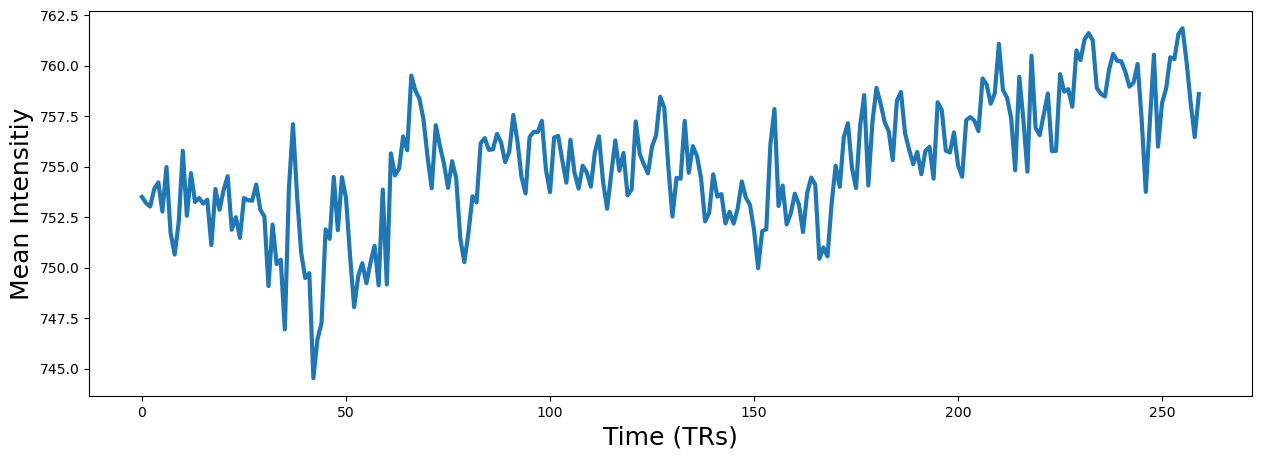

In [13]:
cb_data = smoothed.extract_roi(mask=rois_dict['region08'])

plt.figure(figsize=(15,5))
plt.plot(cb_data, linewidth=3)
plt.ylabel('Mean Intensitiy', fontsize=18)
plt.xlabel('Time (TRs)', fontsize=18)

## Create design matrix

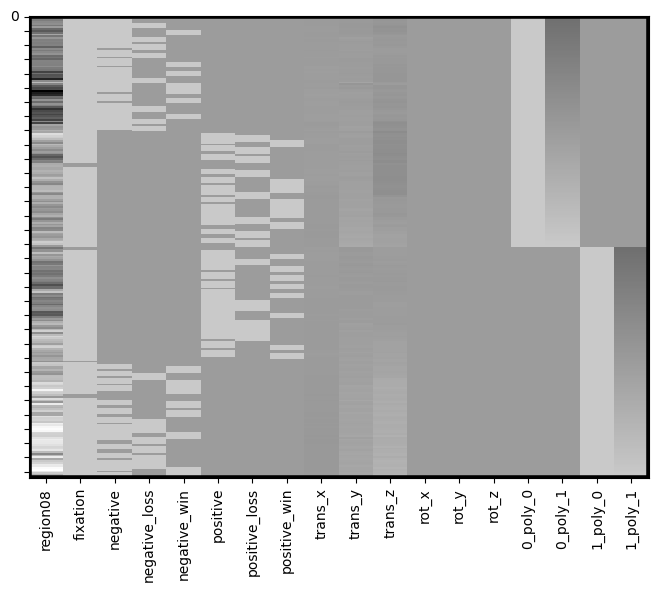

In [15]:
# Set TR info
tr = 2.1
n_tr = len(data)

# z-score cerebellum time series
cb_data = zscore(pd.DataFrame(cb_data, columns=['region08']))


# Append run design matrices
dm = pd.DataFrame()
for run in func_run_names:
    run_n = int(run[-1])
    
    # Import design matrix for a single run
    temp_dm = pd.read_csv(outp_dir+'/design_matrices/'+subj+'_task-'+run+'_desc-design_matrix.csv')

    # Rename the first and second order polynomial regressors so that they do not 
    # regressor between runs
    temp_dm = temp_dm.rename(columns={"poly_0": str(run_n-1)+"_poly_0", "poly_1": str(run_n-1)+"_poly_1"})
    
    # Append design matrix into a longer design matrix
    dm = pd.concat([dm, temp_dm], ignore_index=True)


# Fill NaNs with 0s. NaNs came from renaming columns and then appending the design matrices
dm = dm.fillna(0)

# Join Design matrix with roi time course
dm = Design_Matrix(pd.concat([cb_data, dm], axis=1), sampling_freq=1/tr)

# Plot design matrix
dm.heatmap()

### Create all wins Vs losses contrast

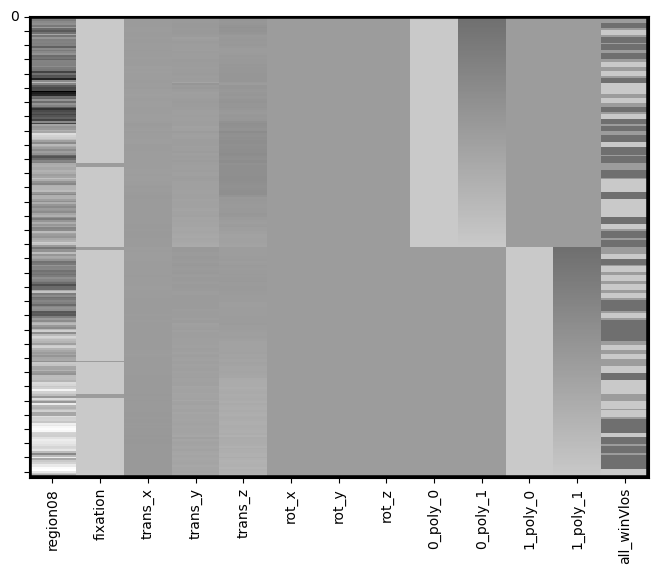

In [16]:
# Set positive and negative valence wins to 1
dm['all_winVlos'] = dm['positive_win'] + dm['negative_win']

# Set positive and negative valence losses to -1
dm['all_winVlos'][dm['negative_loss'] == 1] = -1
dm['all_winVlos'][dm['positive_loss'] == 1] = -1

# Drop other regressors
dm = dm.drop(columns=['negative','negative_loss','negative_win',
                      'positive','positive_loss','positive_win'])


dm.heatmap()


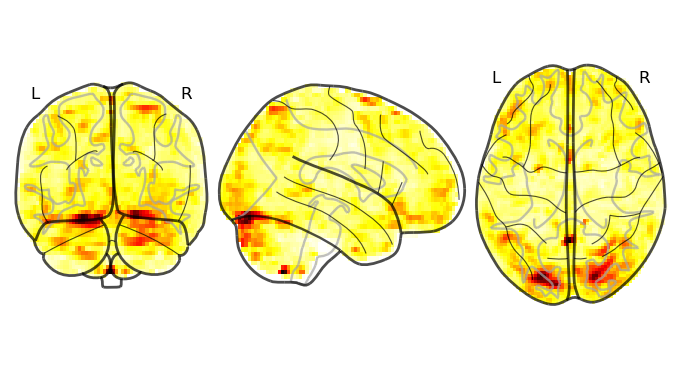

In [18]:
#dm_conv = dm.convolve()

#smoothed.X = dm

#stats = smoothed.regress()

#CB_r_conn = stats['beta'][0]

#CB_r_conn.threshold(upper=10, lower=-10).plot()
#plot_glass_brain(CB_r_conn.to_nifti())

# Psychophysiological Interactions

## Create Design Matrix for PPI

In [19]:
#dm = pd.read_csv(bids_dir+'/derivatives/fmriprep/sub-301/ses-001/func/sub-301_ses-001_task-relscenarios_run-all_cat_desc-design_matrix.csv')
#dm = dm[dm['0_poly_0'] == 1]

In [20]:
#cb_data_dm = Design_Matrix(cb_data, sampling_freq=1/tr).convolve()

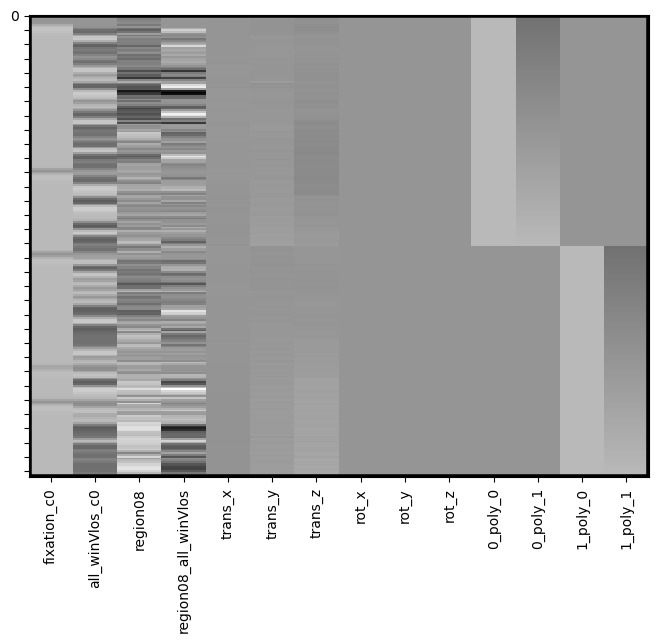

In [21]:
ppi_dm = dm.drop(['region08'], axis=1)

mc_cov = ppi_dm[['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z']]
poly_cov = ppi_dm.loc[:, ppi_dm.columns.str.contains('_poly_')]

ppi_dm = ppi_dm.drop(mc_cov.columns, axis=1)
ppi_dm = ppi_dm.drop(poly_cov.columns, axis=1)

ppi_dm_conv = ppi_dm.convolve()

ppi_dm_conv['region08'] = cb_data

ppi_dm_conv['region08_all_winVlos'] = ppi_dm_conv['region08']*ppi_dm_conv['all_winVlos_c0']

ppi_dm_conv_all = Design_Matrix(pd.concat([ppi_dm_conv, mc_cov, poly_cov], axis=1), sampling_freq=1/tr)


ppi_dm_conv_all.heatmap()

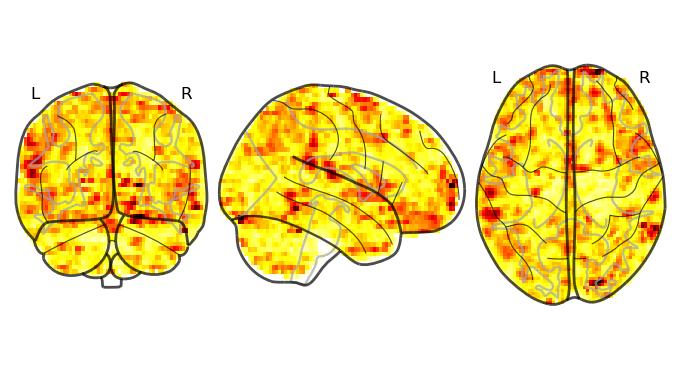

In [22]:
smoothed.X = ppi_dm_conv_all

ppi_stats = smoothed.regress()

cb_r_fixation_ppi = ppi_stats['beta'][int(np.where(smoothed.X.columns=='region08_all_winVlos')[0][0])]

#cb_r_fixation_ppi.plot()
plot_glass_brain(cb_r_fixation_ppi.to_nifti())

In [23]:
#cb_r_fixation_ppi


#nib.Nifti1Image(cb_r_fixation_ppi, tmaps.a.imgaffine)

#nib.save(cb_r_fixation_ppi.to_nifti(), os.path.join(outp_dir, 'test.nii.gz'))
cb_r_fixation_ppi.to_nifti().to_filename(outp_dir+'/test.nii.gz')

# Group PPI Analysis

In [24]:
subjs_list = [x for x in subjs_list if x != 'sub-4069']

In [25]:
all_sub_ppi_cb = Brain_Data()

task = 'social'
roi = 'region08'

for subj in subjs_list:
    print('Calculating PPI for '+subj)
    
    # Import functional runs that passed quality control
    #func_run_nums =  [s.lstrip('0') for s in subjs_scan_info[subjs_scan_info['subject']==subj]['run'].str[-8:-5]]
    #func_run_nums = [int(i) for i in func_run_nums]
    func_run_names = qc_summary[(qc_summary['subject'] == subj) & (qc_summary['run'].str.contains(task))]
    func_run_names = func_run_names['run'].to_list()
    
    print('Number of functional runs for '+subj+': '+str(len(func_run_names)))

    # Find functinoal runs that passed quality control
    func_runs = []
    for run in func_run_names:
        func_runs.append(glob.glob(os.path.join(bids_dir, 'derivatives', 'fmriprep', subj, 'func',
                                   subj+'_task-'+run+'_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'))[0])
    
    
    # Import functional data, masked for only grey matter
    mni_gm_mask = 'derivatives/fmriprep/sub-010/anat/sub-010_space-MNI152NLin2009cAsym_label-GM_probseg_bin.nii.gz'
    #comn_mni_mask = "derivatives/fmriprep/sub-301/ses-001/func/sub-301_ses-001_task-relscenarios_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz"
    data = Brain_Data(func_runs, mask=mni_gm_mask)
    
    
    # Smooth data
    fwhm=6
    smoothed = data.smooth(fwhm=fwhm)
    
    
    # Extract cerebellum ROI data
    cb_data = smoothed.extract_roi(mask=rois_dict[roi])
    
    
    # Get functional meta data
    #tr = layout.get_tr()
    n_tr = len(data)
    
    
    # Z-score cerebellum time series
    cb_data = zscore(pd.DataFrame(cb_data, columns=[roi]))

    
    # Import Design matrix for all runs
    #dm = pd.read_csv(bids_dir+'/derivatives/fmriprep/'+subj+'/ses-001/func/'+subj+'_ses-001_task-relscenarios_run-all_cat_desc-design_matrix.csv')
    #cb_data_dm = Design_Matrix(cb_data, sampling_freq=1/tr).convolve()
    dm = pd.DataFrame()
    for run in func_run_names:
        run_n = int(run[-1])
        # Import design matrix for a single run
        temp_dm = pd.read_csv(outp_dir+'/design_matrices/'+subj+'_task-'+run+'_desc-design_matrix.csv')
        # Rename the first and second order polynomial regressors so that they do not 
        # regressor between runs
        temp_dm = temp_dm.rename(columns={"poly_0": str(n-1)+"_poly_0", "poly_1": str(n-1)+"_poly_1"})

        # Append design matrix into a longer design matrix
        #dm = dm.append(temp_dm, ignore_index=True)
        dm = pd.concat([dm, temp_dm], ignore_index=True)
        
    # Fill NaNs with 0s. NaNs came from renaming columns and then appending the design matrices
    dm = dm.fillna(0)
    
    # Combine cerebellum time series with the design matrix
    #ppi_dm = Design_Matrix(pd.concat([cb_data, dm], axis=1), sampling_freq=1/tr)
    
    # Create contrast
    dm['all_winVlos'] = dm['positive_win'] + dm['negative_win']
    dm['all_winVlos'][dm['negative_loss'] == 1] = -1
    dm['all_winVlos'][dm['positive_loss'] == 1] = -1

    # Drop other regressors
    dm = dm.drop(columns=['negative','negative_loss','negative_win',
                          'positive','positive_loss','positive_win'])
    #ppi_dm = dm.drop(['CB_r'], axis=1)

    mc_cov = dm[['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z']]
    poly_cov = dm.loc[:, dm.columns.str.contains('_poly_')]

    ppi_dm = dm.drop(mc_cov.columns, axis=1)
    ppi_dm = ppi_dm.drop(poly_cov.columns, axis=1)
    
    ppi_dm = Design_Matrix(ppi_dm, sampling_freq=1/tr)
    ppi_dm_conv = ppi_dm.convolve()

    ppi_dm_conv[roi] = cb_data

    ppi_dm_conv[roi+'_all_winVlos'] = ppi_dm_conv[roi]*ppi_dm_conv['all_winVlos_c0']

    ppi_dm_conv_all = Design_Matrix(pd.concat([ppi_dm_conv, mc_cov, poly_cov], axis=1), sampling_freq=1/tr)
    
    
    # Convolve design matrix
    #ppi_dm_conv = ppi_dm.convolve()
    
    
    # Calculate interaction term
    #ppi_dm_conv['CB_r_All'] = ppi_dm_conv['CB_r_c0']*ppi_dm_conv['All_c0']
    
    
    # Run PPI
    smoothed.X = ppi_dm_conv_all
    ppi_stats = smoothed.regress()
    cb_r_fixation_ppi = ppi_stats['beta'][int(np.where(smoothed.X.columns==roi+'_all_winVlos')[0][0])]
    
    
    # Export PPI map
    cb_r_fixation_ppi.to_nifti().to_filename(outp_dir+'/subject_results/'+subj+'_ppi_'+roi+'.nii.gz')
    
    
    # Append subject data
    all_sub_ppi_cb = all_sub_ppi_cb.append(cb_r_fixation_ppi)

Calculating PPI for sub-010
Number of functional runs for sub-010: 2
Calculating PPI for sub-013
Number of functional runs for sub-013: 2
Calculating PPI for sub-028
Number of functional runs for sub-028: 2
Calculating PPI for sub-036
Number of functional runs for sub-036: 2
Calculating PPI for sub-3845
Number of functional runs for sub-3845: 2
Calculating PPI for sub-3846
Number of functional runs for sub-3846: 2
Calculating PPI for sub-3848
Number of functional runs for sub-3848: 2
Calculating PPI for sub-3849
Number of functional runs for sub-3849: 2
Calculating PPI for sub-3852
Number of functional runs for sub-3852: 2
Calculating PPI for sub-3855
Number of functional runs for sub-3855: 2
Calculating PPI for sub-3864
Number of functional runs for sub-3864: 2
Calculating PPI for sub-3865
Number of functional runs for sub-3865: 2
Calculating PPI for sub-3874
Number of functional runs for sub-3874: 2
Calculating PPI for sub-3880
Number of functional runs for sub-3880: 2
Calculating PP

# All Participants Group Average

In [26]:
stats_all = all_sub_ppi_cb.ttest(threshold_dict={'fdr':.05})
stats_all['t'].write(os.path.join(outp_dir, 'group_results', 'tmap_ppi_cb_unc.nii.gz'))
stats_all['thr_t'].write(os.path.join(outp_dir, 'group_results', 'tmap_ppi_cb_fdr05.nii.gz'))


/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/masking.py:974: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(mask_img, unmasked, affine)


/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/masking.py:974: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(mask_img, unmasked, affine)
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/plotting/displays/_slicers.py:438: UserWarning: empty mask
  xmin_, xmax_, ymin_, ymax_, zmin_, zmax_ = get_mask_bounds(


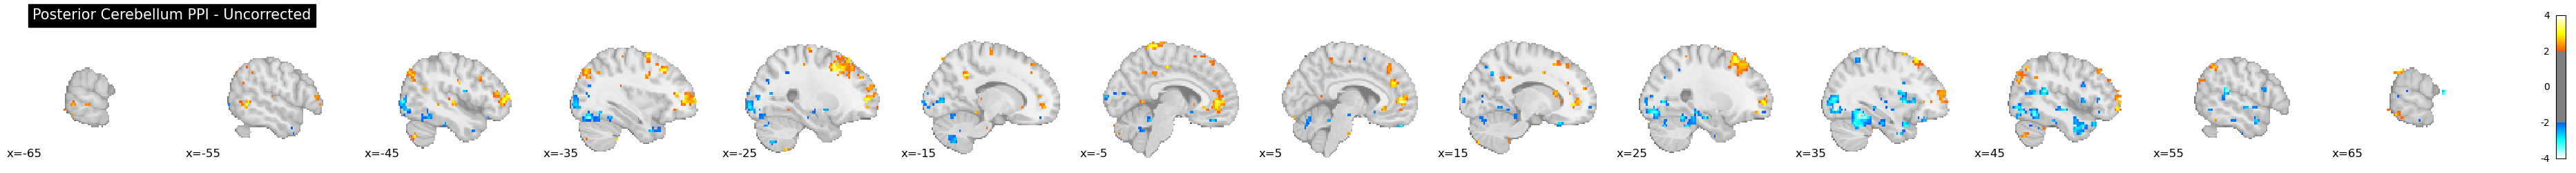

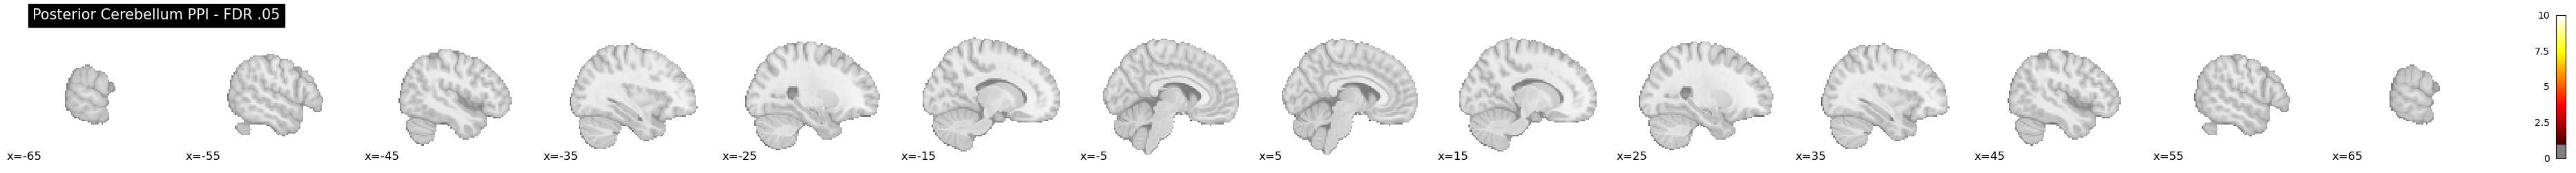

In [27]:
results_uncr = plot_stat_map(stats_all['t'].to_nifti(), threshold=2,
    cut_coords=range(-65, 66, 10), display_mode='x', vmax=4, colorbar=True,
    title='Posterior Cerebellum PPI - Uncorrected')

results_plot = plot_stat_map(stats_all['thr_t'].to_nifti(), threshold=1,
                cut_coords=range(-65, 66, 10), display_mode='x', vmax=10, colorbar=True,
                title='Posterior Cerebellum PPI - FDR .05')
results_plot

results_plot.savefig(outp_dir+'/group_results/tmap_ppi_cb_fdr05.png')
results_uncr.savefig(outp_dir+'/group_results/tmap_ppi_cb_unc.png')

In [28]:
from nilearn import plotting
from nilearn import surface
from nilearn import datasets

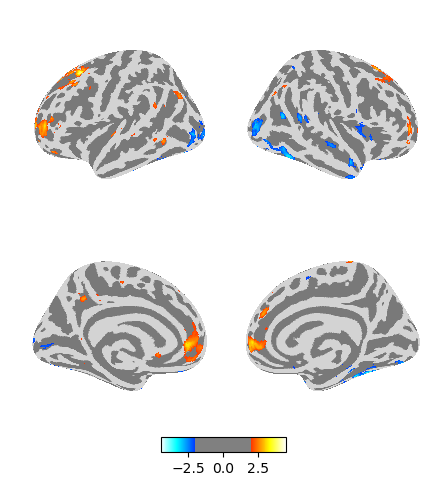

<Figure size 640x480 with 0 Axes>

In [29]:
plotting.plot_img_on_surf(stats_all['t'].to_nifti(),
                          views=['lateral', 'medial'],
                          hemispheres=['left', 'right'],
                          inflate=True,
                          threshold=2.0,
                          surf_mesh='fsaverage',
                          #cmap='blue_orange',
                          colorbar=True)

plotting.show()
plt.savefig(outp_dir+'/group_results/tmap_ppi_cb_unc_surf.png')
#fig.savefig(outp_dir+'/group_results/tmap_ppi_cb_unc_surf.png')

/tmp/ipykernel_184455/1971714618.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure.show()


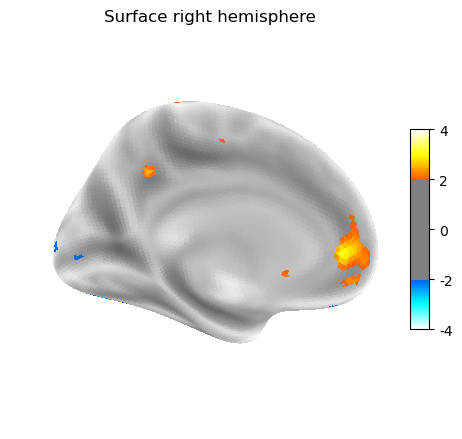

In [30]:
fsaverage = datasets.fetch_surf_fsaverage()

texture = surface.vol_to_surf(stats_all['t'].to_nifti(), fsaverage.pial_left)

figure = plotting.plot_surf_stat_map(fsaverage.infl_left, texture, hemi='left',
                                     view='medial',
                                     title='Surface right hemisphere',
                                     colorbar=True, threshold=2.,
                                     bg_map=fsaverage.sulc_left)

figure.show()

# Young Adults

In [38]:
subjs_scan_info = subjs_scan_info[subjs_scan_info['participant_id'] != 'sub-4069']

In [47]:
# Create list of young adult data
subjs_scan_info_adult = subjs_scan_info[subjs_scan_info['group'] == 'college']
print('There are ' + str(len(subjs_scan_info_adult))+ ' young adults')

# Find PPI maps
file_list_adult_ppi = []

for subj in subjs_scan_info_adult['participant_id']:
    file_list_adult_ppi.append(glob.glob(os.path.join(outp_dir+'/subject_results/'+subj+'_ppi_region08.nii.gz'))[0])


print('Found '+str(len(file_list_adult_ppi))+' subject maps')

There are 30 young adults
Found 30 subject maps


In [48]:
# Load data
ppi_data = Brain_Data(file_list_adult_ppi, mask=mni_gm_mask)

# Perform one sample t-test and multiple comparisons correction
ppi_data_stats = ppi_data.ttest(threshold_dict={'fdr':.05})

# Export as nifti
ppi_data_stats['t'].write(os.path.join(outp_dir+'group_adult_ppi_region08_unc.nii.gz'))
ppi_data_stats['thr_t'].write(os.path.join(outp_dir+'group_adult_ppi_region08_fdr05.nii.gz'))


/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/masking.py:974: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(mask_img, unmasked, affine)


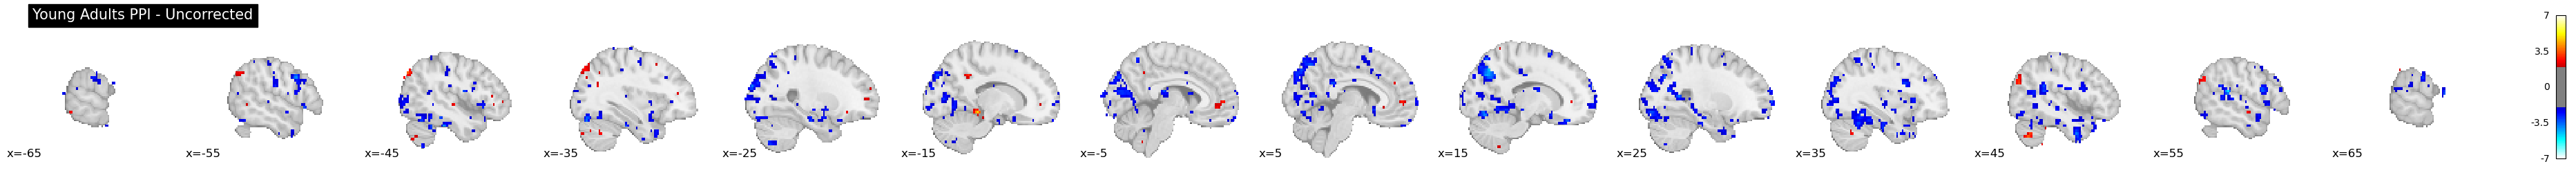

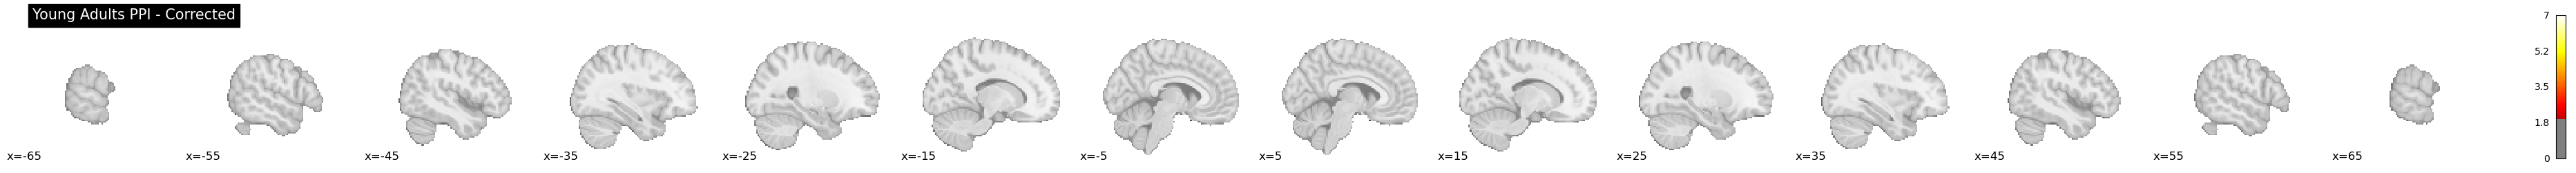

In [50]:
plot_stat_map(ppi_data_stats['t'].to_nifti(), threshold=2, vmax=7,
              cut_coords=range(-65,66,10), display_mode='x', colorbar=True,
              title='Young Adults PPI - Uncorrected')
plot_stat_map(ppi_data_stats['thr_t'].to_nifti(), threshold=2, vmax=7,
              cut_coords=range(-65,66,10), display_mode='x', colorbar=True,
              title='Young Adults PPI - Corrected')

# Adolescents

In [51]:
# Create list of young adult data
subjs_scan_info_adole = subjs_scan_info[subjs_scan_info['group'] == 'kid']
print('There are ' + str(len(subjs_scan_info_adole))+ ' adolescents')

# Find PPI maps
file_list_adole_ppi = []

for subj in subjs_scan_info_adole['participant_id']:
    file_list_adole_ppi.append(glob.glob(os.path.join(outp_dir+'/subject_results/'+subj+'_ppi_region08.nii.gz'))[0])


print('Found '+str(len(file_list_adole_ppi))+' subject maps')

There are 32 adolescents
Found 32 subject maps


In [52]:
# Load data
ppi_data = Brain_Data(file_list_adole_ppi, mask=mni_gm_mask)

# Perform one sample t-test and multiple comparisons correction
ppi_data_stats = ppi_data.ttest(threshold_dict={'fdr':.05})

# Export as nifti
ppi_data_stats['t'].write(os.path.join(outp_dir+'group_adole_ppi_region08_unc.nii.gz'))
ppi_data_stats['thr_t'].write(os.path.join(outp_dir+'group_adole_ppi_region08_fdr05.nii.gz'))

/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/masking.py:974: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(mask_img, unmasked, affine)


/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/plotting/displays/_slicers.py:438: UserWarning: empty mask
  xmin_, xmax_, ymin_, ymax_, zmin_, zmax_ = get_mask_bounds(


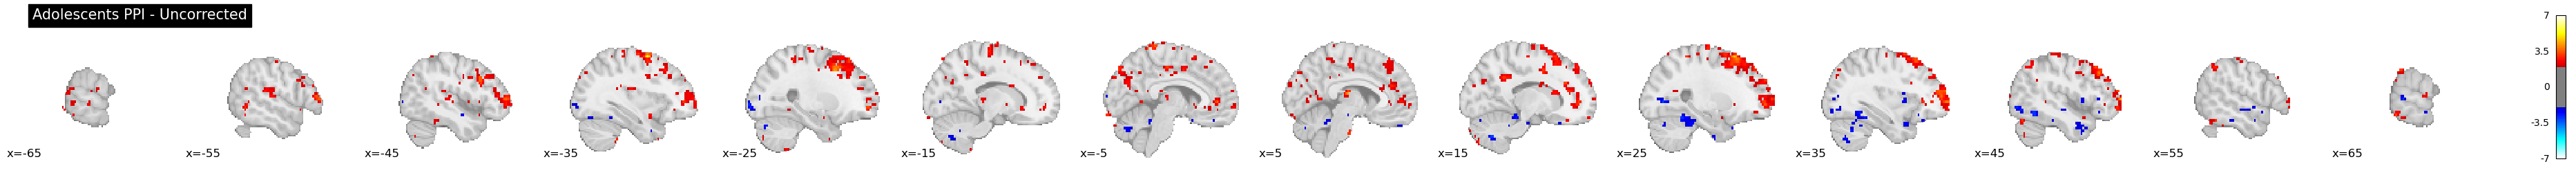

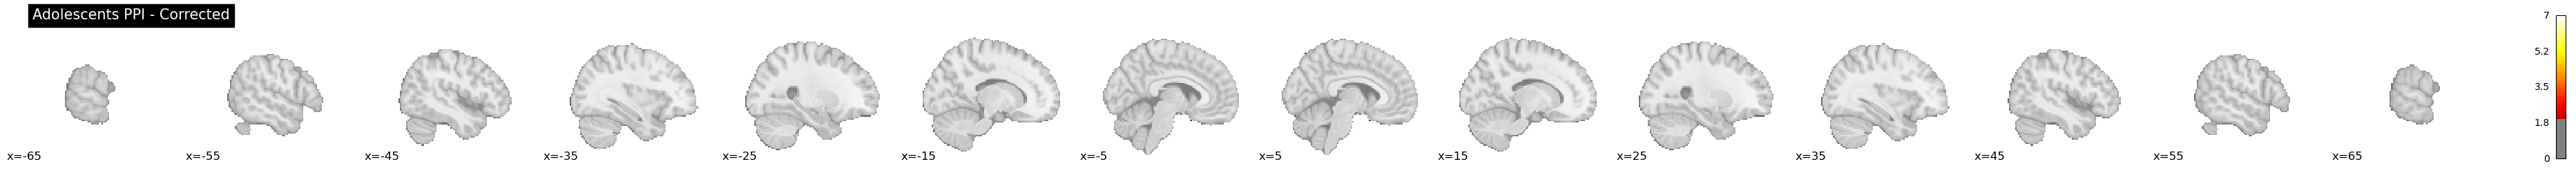

In [53]:
plot_stat_map(ppi_data_stats['t'].to_nifti(), threshold=2, vmax=7,
              cut_coords=range(-65,66,10), display_mode='x', colorbar=True,
              title='Adolescents PPI - Uncorrected')
plot_stat_map(ppi_data_stats['thr_t'].to_nifti(), threshold=2, vmax=7,
              cut_coords=range(-65,66,10), display_mode='x', colorbar=True,
              title='Adolescents PPI - Corrected')

# Between Groups

## Second Level Design Matrix

In [58]:
subjs_scan_info

,Unnamed: 0,participant_id,age,sex,group
0,0,sub-010,13,F,kid
1,2,sub-013,13,M,kid
2,5,sub-028,15,M,kid
3,6,sub-036,16,F,kid
4,7,sub-5049,12,F,kid
...,...,...,...,...,...
57,75,sub-4020,20,F,college
59,77,sub-6003,23,M,college
60,78,sub-6004,19,M,college
61,79,sub-6005,21,F,college


In [57]:
subjs_info_num

,participant_id,group
0,sub-010,1
1,sub-013,1
2,sub-028,1
3,sub-036,1
4,sub-5049,1
...,...,...
57,sub-4020,-1
59,sub-6003,-1
60,sub-6004,-1
61,sub-6005,-1


<Axes: label='conditions', ylabel='scan number'>

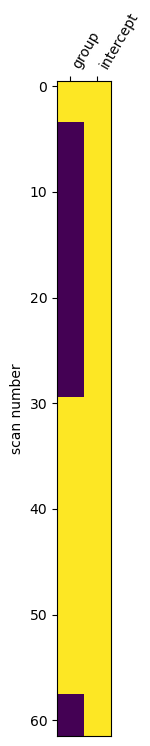

In [77]:
from nilearn.glm.second_level import make_second_level_design_matrix
from nilearn.plotting import plot_design_matrix
from nilearn.glm.second_level import SecondLevelModel
from nilearn.glm import threshold_stats_img



# Make a copy for the design matrix df
subjs_info_num = subjs_scan_info.copy()

# Turn values numeric
subjs_info_num = subjs_info_num.replace({'group': {'college': -1, 'kid': 1}})

# Remove irrelevant info
subjs_info_num = subjs_info_num.drop(columns=['age', 'sex', 'Unnamed: 0'])

# Change column header for needed function input
subjs_info_num = subjs_info_num.rename({'participant_id':'subject_label'}, axis='columns')

design_matrix = make_second_level_design_matrix(subjs_list, subjs_info_num)

plot_design_matrix(design_matrix)

In [84]:
# Find PPI data
file_list = []
for subj in subjs_list:
    file_list.append(glob.glob(os.path.join(outp_dir+'/subject_results/'+subj+'_ppi_region08.nii.gz'))[0])

# Create second level model
model = SecondLevelModel(mask_img=mni_gm_mask, smoothing_fwhm=8.0)
model.fit(file_list, design_matrix=design_matrix)
    
# Create group map
z_map = model.compute_contrast('group', output_type='z_score')
z_map.to_filename(os.path.join(outp_dir+'zmap_adoleVadult_ppi_region08_unc.nii.gz'))

# Multiple comparisons correction
z_map_thresh, threshold = threshold_stats_img(z_map, alpha=.001, height_control='fpr')
z_map_thresh.to_filename(os.path.join(data_dir,'group',
                                      'zmap_adoleVadult_ppi_region08_fdr05.nii.gz'))

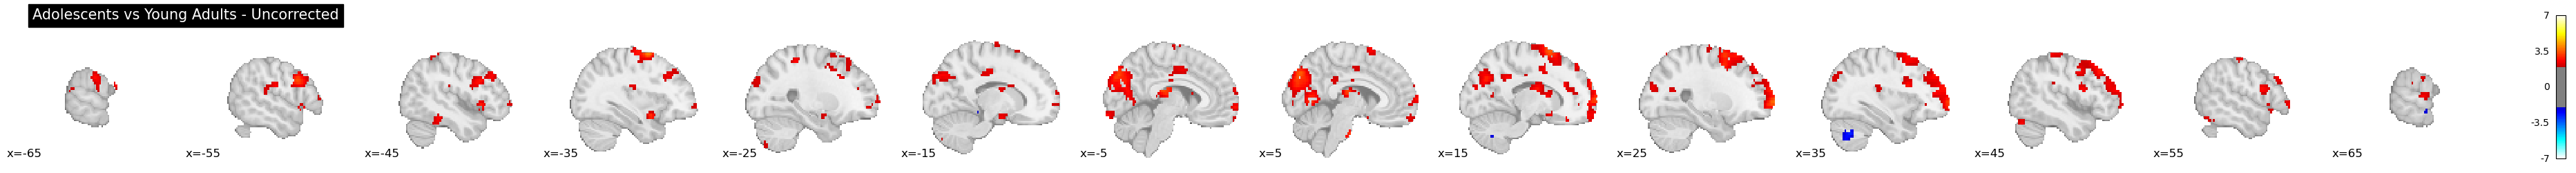

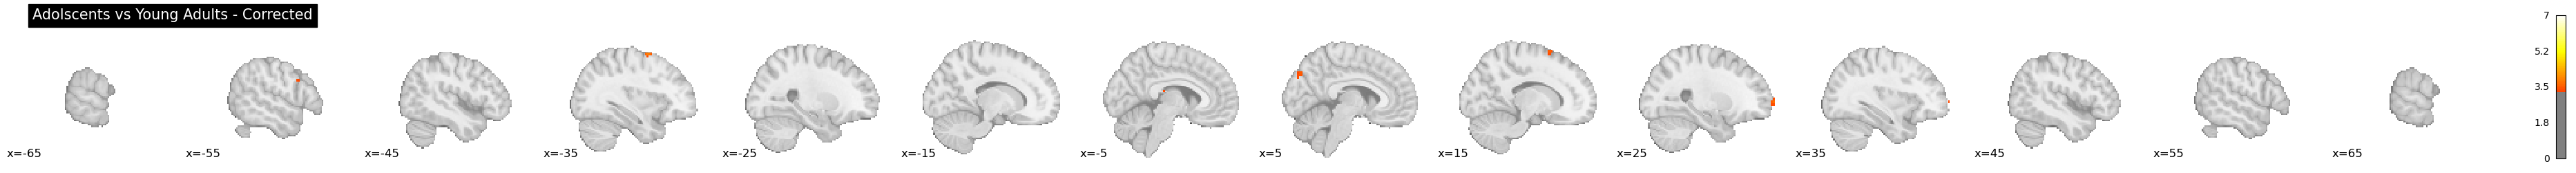

In [85]:
plot_stat_map(z_map, threshold=2, vmax=7,
              cut_coords=range(-65,66,10), display_mode='x', colorbar=True,
              title='Adolescents vs Young Adults - Uncorrected')
plot_stat_map(z_map_thresh, threshold=threshold, vmax=7,
              cut_coords=range(-65,66,10), display_mode='x', colorbar=True,
              title='Adolscents vs Young Adults - Corrected')

***

# Network PPI

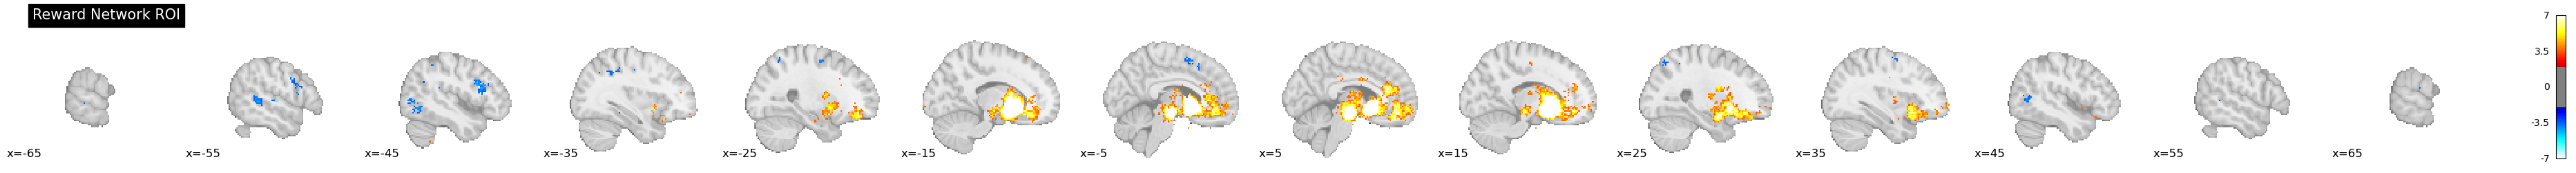

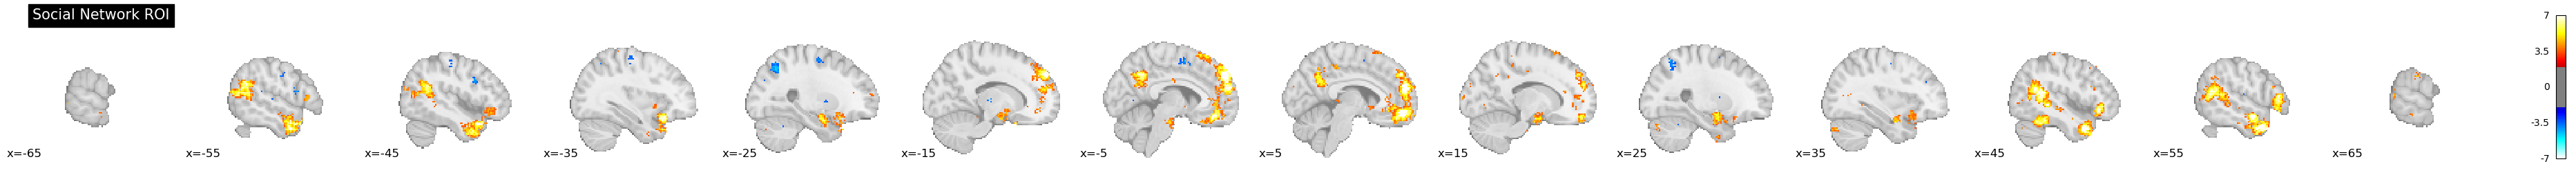

In [97]:
# Load network ROIs
reward_net_roi_file = os.path.join(bids_dir,'derivatives','rois','reward_association-test_z_FDR_0.01.nii.gz')
social_net_roi_file = os.path.join(bids_dir,'derivatives','rois','social_association-test_z_FDR_0.01.nii.gz')

# Visualize
plot_stat_map(reward_net_roi_file, threshold=2, vmax=7,
              cut_coords=range(-65,66,10), display_mode='x',
              title='Reward Network ROI')
plot_stat_map(social_net_roi_file, threshold=2, vmax=7,
              cut_coords=range(-65,66,10), display_mode='x',
              title='Social Network ROI')

Some of these network ROIs have cerebellum regions. We will filter the cerebellum out of these networks so they do not conflict with the cerebellum PPI analysis, using the cerebellum MDTB atlas from King et al., 2019.

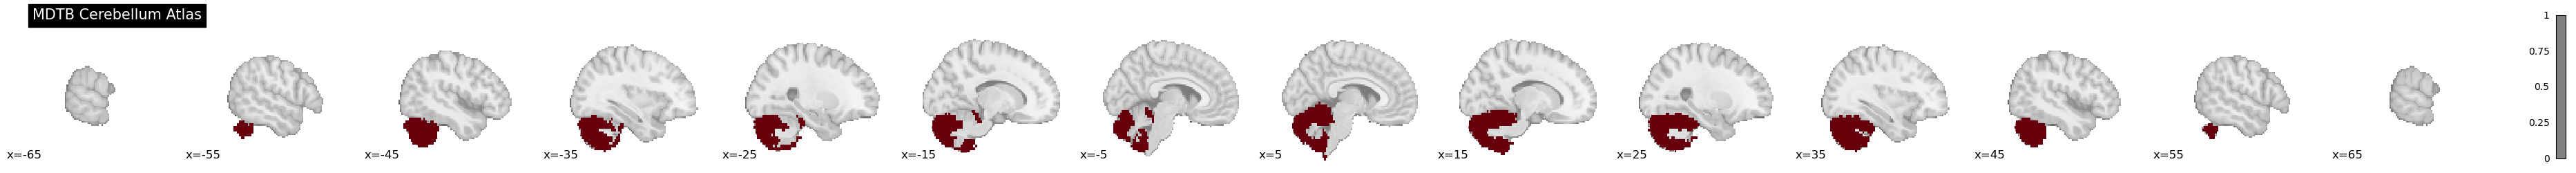

In [98]:
# Load cerebellum atlas
mdtb_cb_roi_file = os.path.join(bids_dir,'derivatives','rois','atl-MDTB10_space-MNI152NLing2009cAsym.nii')

# Visualize
plot_stat_map(mdtb_cb_roi_file, threshold=1, vmax=1, cmap='Reds',
              cut_coords=range(-65,66,10), display_mode='x',
              title='MDTB Cerebellum Atlas')

/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


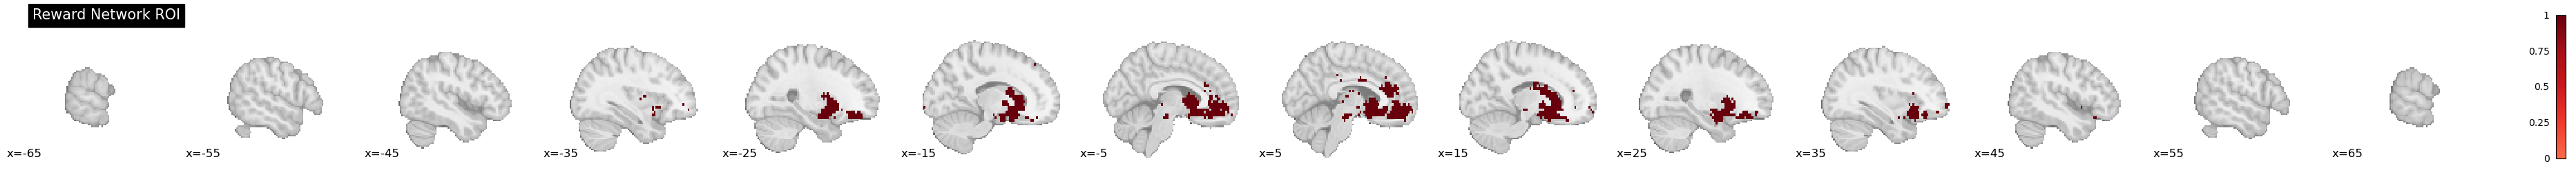

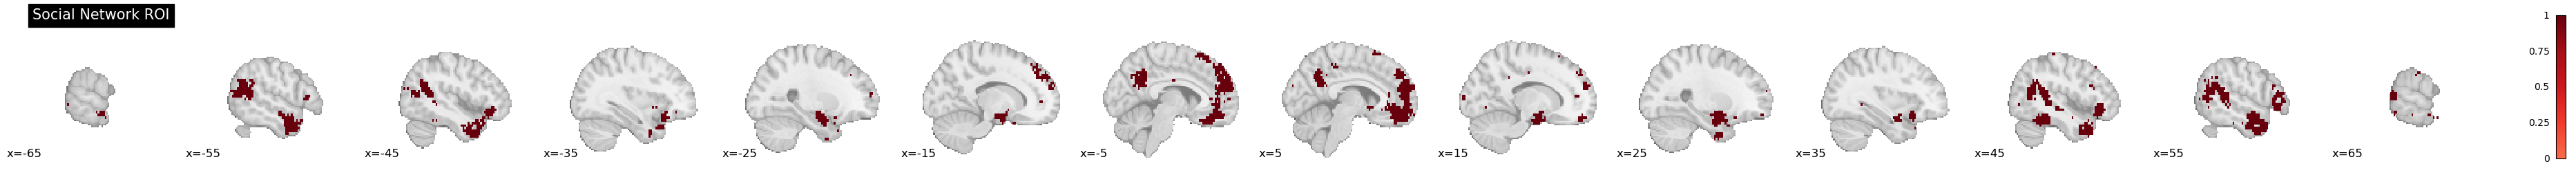

In [108]:
from nilearn.image import math_img

# Load roi
reward_net_roi = Brain_Data(reward_net_roi_file, mask=mni_gm_mask)
social_net_roi = Brain_Data(social_net_roi_file, mask=mni_gm_mask)
mdtb_cb_roi = Brain_Data(mdtb_cb_roi_file, mask=mni_gm_mask)

# Subtract the cerebellum from the network ROI masks
reward_net_roi = math_img("img1 - img2", img1=reward_net_roi.to_nifti(), img2=mdtb_cb_roi.to_nifti())
social_net_roi = math_img("img1 - img2", img1=social_net_roi.to_nifti(), img2=mdtb_cb_roi.to_nifti())

# Binarize
reward_net_roi = math_img('img > 1', img=reward_net_roi)
social_net_roi = math_img('img > 1', img=social_net_roi)

# Visualize
plot_stat_map(reward_net_roi, threshold=0, vmax=1, cmap='Reds',
              cut_coords=range(-65,66,10), display_mode='x',
              title='Reward Network ROI')
plot_stat_map(social_net_roi, threshold=0, vmax=1, cmap='Reds',
              cut_coords=range(-65,66,10), display_mode='x',
              title='Social Network ROI')

In [109]:
nuis_networks = {'reward':reward_net_roi, 'social':social_net_roi}
nuis_networks

{'reward': <nibabel.nifti1.Nifti1Image at 0x7efcaf72ba10>,
 'social': <nibabel.nifti1.Nifti1Image at 0x7efcb0fe3010>}

In [111]:
all_sub_ppi_cb = Brain_Data()

task = 'social'
roi = 'region08'

nuis_networks = {'reward':reward_net_roi, 'social':social_net_roi}

for subj in subjs_list:
    print('Calculating PPI for '+subj)
    
    # Import functional runs that passed quality control
    #func_run_nums =  [s.lstrip('0') for s in subjs_scan_info[subjs_scan_info['subject']==subj]['run'].str[-8:-5]]
    #func_run_nums = [int(i) for i in func_run_nums]
    func_run_names = qc_summary[(qc_summary['subject'] == subj) & (qc_summary['run'].str.contains(task))]
    func_run_names = func_run_names['run'].to_list()
    
    print('Number of functional runs for '+subj+': '+str(len(func_run_names)))

    # Find functinoal runs that passed quality control
    func_runs = []
    for run in func_run_names:
        func_runs.append(glob.glob(os.path.join(bids_dir, 'derivatives', 'fmriprep', subj, 'func',
                                   subj+'_task-'+run+'_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'))[0])
    
    
    # Import functional data, masked for only grey matter
    mni_gm_mask = 'derivatives/fmriprep/sub-010/anat/sub-010_space-MNI152NLin2009cAsym_label-GM_probseg_bin.nii.gz'
    #comn_mni_mask = "derivatives/fmriprep/sub-301/ses-001/func/sub-301_ses-001_task-relscenarios_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz"
    data = Brain_Data(func_runs, mask=mni_gm_mask)
    
    
    # Smooth data
    fwhm=6
    smoothed = data.smooth(fwhm=fwhm)
    
    
    # Extract cerebellum ROI data
    cb_data = smoothed.extract_roi(mask=rois_dict[roi])
    
    # Extract network ROIs data
    reward_net_data = smoothed.extract_roi(mask=reward_net_roi)
    social_net_data = smoothed.extract_roi(mask=social_net_roi)
    
    
    # Get functional meta data
    #tr = layout.get_tr()
    n_tr = len(data)
    
    
    # Z-score time series
    cb_data = zscore(pd.DataFrame(cb_data, columns=[roi]))
    reward_net_data = zscore(pd.DataFrame(reward_net_data, columns=['reward_network']))
    social_net_data = zscore(pd.DataFrame(social_net_data, columns=['social_network']))

    
    # Import Design matrix for all runs
    #dm = pd.read_csv(bids_dir+'/derivatives/fmriprep/'+subj+'/ses-001/func/'+subj+'_ses-001_task-relscenarios_run-all_cat_desc-design_matrix.csv')
    #cb_data_dm = Design_Matrix(cb_data, sampling_freq=1/tr).convolve()
    dm = pd.DataFrame()
    for run in func_run_names:
        run_n = int(run[-1])
        # Import design matrix for a single run
        temp_dm = pd.read_csv(outp_dir+'/design_matrices/'+subj+'_task-'+run+'_desc-design_matrix.csv')
        # Rename the first and second order polynomial regressors so that they do not 
        # regressor between runs
        temp_dm = temp_dm.rename(columns={"poly_0": str(n-1)+"_poly_0", "poly_1": str(n-1)+"_poly_1"})

        # Append design matrix into a longer design matrix
        #dm = dm.append(temp_dm, ignore_index=True)
        dm = pd.concat([dm, temp_dm], ignore_index=True)
        
    # Fill NaNs with 0s. NaNs came from renaming columns and then appending the design matrices
    dm = dm.fillna(0)
    
    # Combine cerebellum time series with the design matrix
    #ppi_dm = Design_Matrix(pd.concat([cb_data, dm], axis=1), sampling_freq=1/tr)
    
    # Create contrast
    dm['all_winVlos'] = dm['positive_win'] + dm['negative_win']
    dm['all_winVlos'][dm['negative_loss'] == 1] = -1
    dm['all_winVlos'][dm['positive_loss'] == 1] = -1

    # Drop other regressors
    dm = dm.drop(columns=['negative','negative_loss','negative_win',
                          'positive','positive_loss','positive_win'])
    #ppi_dm = dm.drop(['CB_r'], axis=1)

    mc_cov = dm[['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z']]
    poly_cov = dm.loc[:, dm.columns.str.contains('_poly_')]

    ppi_dm = dm.drop(mc_cov.columns, axis=1)
    ppi_dm = ppi_dm.drop(poly_cov.columns, axis=1)
    
    ppi_dm = Design_Matrix(ppi_dm, sampling_freq=1/tr)
    
    
    nuis_networks = {'reward':reward_net_data, 'social':social_net_data}
    for nuis_net in nuis_networks.keys():
        ppi_dm_conv = ppi_dm.convolve()

        ppi_dm_conv[roi] = cb_data
        ppi_dm_conv[nuis_net] = nuis_networks[nuis_net]

        ppi_dm_conv[roi+'_all_winVlos'] = ppi_dm_conv[roi]*ppi_dm_conv['all_winVlos_c0']

        ppi_dm_conv_all = Design_Matrix(pd.concat([ppi_dm_conv, mc_cov, poly_cov], axis=1), sampling_freq=1/tr)


        # Convolve design matrix
        #ppi_dm_conv = ppi_dm.convolve()


        # Calculate interaction term
        #ppi_dm_conv['CB_r_All'] = ppi_dm_conv['CB_r_c0']*ppi_dm_conv['All_c0']


        # Run PPI
        smoothed.X = ppi_dm_conv_all
        ppi_stats = smoothed.regress()
        cb_r_fixation_ppi = ppi_stats['beta'][int(np.where(smoothed.X.columns==roi+'_all_winVlos')[0][0])]


        # Export PPI map
        cb_r_fixation_ppi.to_nifti().to_filename(outp_dir+'/subject_results/'+subj+'_ppi_'+roi+'nuis-'+nuis_net+'.nii.gz')


        # Append subject data
        all_sub_ppi_cb = all_sub_ppi_cb.append(cb_r_fixation_ppi)

Calculating PPI for sub-010
Number of functional runs for sub-010: 2


/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/image/resampling.py:291: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr

Calculating PPI for sub-013
Number of functional runs for sub-013: 2


/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/image/resampling.py:291: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr

Calculating PPI for sub-028
Number of functional runs for sub-028: 2


/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/image/resampling.py:291: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr

Calculating PPI for sub-036
Number of functional runs for sub-036: 2


/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/image/resampling.py:291: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr

Calculating PPI for sub-3845
Number of functional runs for sub-3845: 2


/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/image/resampling.py:291: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr

Calculating PPI for sub-3846
Number of functional runs for sub-3846: 2


/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/image/resampling.py:291: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr

Calculating PPI for sub-3848
Number of functional runs for sub-3848: 2


/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/image/resampling.py:291: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr

Calculating PPI for sub-3849
Number of functional runs for sub-3849: 2


/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/image/resampling.py:291: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr

Calculating PPI for sub-3852
Number of functional runs for sub-3852: 2


/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/image/resampling.py:291: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr

Calculating PPI for sub-3855
Number of functional runs for sub-3855: 2


/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/image/resampling.py:291: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr

Calculating PPI for sub-3864
Number of functional runs for sub-3864: 2


/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/image/resampling.py:291: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr

Calculating PPI for sub-3865
Number of functional runs for sub-3865: 2


/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/image/resampling.py:291: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr

Calculating PPI for sub-3874
Number of functional runs for sub-3874: 2


/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/image/resampling.py:291: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr

Calculating PPI for sub-3880
Number of functional runs for sub-3880: 2


/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/image/resampling.py:291: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr

Calculating PPI for sub-3883
Number of functional runs for sub-3883: 2


/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/image/resampling.py:291: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr

Calculating PPI for sub-3886
Number of functional runs for sub-3886: 2


/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/image/resampling.py:291: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr

Calculating PPI for sub-3887
Number of functional runs for sub-3887: 2


/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/image/resampling.py:291: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr

Calculating PPI for sub-3890
Number of functional runs for sub-3890: 2


/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/image/resampling.py:291: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr

Calculating PPI for sub-3892
Number of functional runs for sub-3892: 2


/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/image/resampling.py:291: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr

Calculating PPI for sub-3893
Number of functional runs for sub-3893: 2


/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/image/resampling.py:291: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr

Calculating PPI for sub-3895
Number of functional runs for sub-3895: 2


/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/image/resampling.py:291: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr

Calculating PPI for sub-3912
Number of functional runs for sub-3912: 2


/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/image/resampling.py:291: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr

Calculating PPI for sub-3920
Number of functional runs for sub-3920: 2


/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/image/resampling.py:291: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr

Calculating PPI for sub-3967
Number of functional runs for sub-3967: 2


/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/image/resampling.py:291: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr

Calculating PPI for sub-3989
Number of functional runs for sub-3989: 2


/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/image/resampling.py:291: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr

Calculating PPI for sub-4011
Number of functional runs for sub-4011: 2


/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/image/resampling.py:291: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr

Calculating PPI for sub-4017
Number of functional runs for sub-4017: 2


/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/image/resampling.py:291: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr

Calculating PPI for sub-4018
Number of functional runs for sub-4018: 2


/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/image/resampling.py:291: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr

Calculating PPI for sub-4019
Number of functional runs for sub-4019: 2


/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/image/resampling.py:291: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr

Calculating PPI for sub-4020
Number of functional runs for sub-4020: 2


/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/image/resampling.py:291: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr

Calculating PPI for sub-5049
Number of functional runs for sub-5049: 2


/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/image/resampling.py:291: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr

Calculating PPI for sub-5051
Number of functional runs for sub-5051: 2


/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/image/resampling.py:291: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr

Calculating PPI for sub-5054
Number of functional runs for sub-5054: 2


/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/image/resampling.py:291: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr

Calculating PPI for sub-5058
Number of functional runs for sub-5058: 2


/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/image/resampling.py:291: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr

Calculating PPI for sub-5064
Number of functional runs for sub-5064: 2


/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/image/resampling.py:291: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr

Calculating PPI for sub-5067
Number of functional runs for sub-5067: 2


/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/image/resampling.py:291: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr

Calculating PPI for sub-5068
Number of functional runs for sub-5068: 2


/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/image/resampling.py:291: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr

Calculating PPI for sub-5082
Number of functional runs for sub-5082: 2


/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/image/resampling.py:291: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr

Calculating PPI for sub-5083
Number of functional runs for sub-5083: 2


/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/image/resampling.py:291: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr

Calculating PPI for sub-5084
Number of functional runs for sub-5084: 2


/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/image/resampling.py:291: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr

Calculating PPI for sub-5085
Number of functional runs for sub-5085: 2


/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/image/resampling.py:291: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr

Calculating PPI for sub-5090
Number of functional runs for sub-5090: 2


/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/image/resampling.py:291: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr

Calculating PPI for sub-5091
Number of functional runs for sub-5091: 2


/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/image/resampling.py:291: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr

Calculating PPI for sub-5092
Number of functional runs for sub-5092: 2


/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/image/resampling.py:291: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr

Calculating PPI for sub-5093
Number of functional runs for sub-5093: 2


/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/image/resampling.py:291: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr

Calculating PPI for sub-5094
Number of functional runs for sub-5094: 2


/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/image/resampling.py:291: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr

Calculating PPI for sub-5095
Number of functional runs for sub-5095: 2


/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/image/resampling.py:291: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr

Calculating PPI for sub-5098
Number of functional runs for sub-5098: 2


/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/image/resampling.py:291: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr

Calculating PPI for sub-5102
Number of functional runs for sub-5102: 2


/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/image/resampling.py:291: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr

Calculating PPI for sub-5108
Number of functional runs for sub-5108: 2


/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/image/resampling.py:291: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr

Calculating PPI for sub-5125
Number of functional runs for sub-5125: 2


/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/image/resampling.py:291: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr

Calculating PPI for sub-5126
Number of functional runs for sub-5126: 2


/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/image/resampling.py:291: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr

Calculating PPI for sub-5130
Number of functional runs for sub-5130: 2


/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/image/resampling.py:291: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr

Calculating PPI for sub-5131
Number of functional runs for sub-5131: 2


/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/image/resampling.py:291: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr

Calculating PPI for sub-5133
Number of functional runs for sub-5133: 2


/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/image/resampling.py:291: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr

Calculating PPI for sub-5136
Number of functional runs for sub-5136: 2


/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/image/resampling.py:291: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr

Calculating PPI for sub-5140
Number of functional runs for sub-5140: 2


/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/image/resampling.py:291: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr

Calculating PPI for sub-5145
Number of functional runs for sub-5145: 2


/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/image/resampling.py:291: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr

Calculating PPI for sub-6003
Number of functional runs for sub-6003: 2


/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/image/resampling.py:291: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr

Calculating PPI for sub-6004
Number of functional runs for sub-6004: 2


/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/image/resampling.py:291: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr

Calculating PPI for sub-6005
Number of functional runs for sub-6005: 2


/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/image/resampling.py:291: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr

Calculating PPI for sub-6006
Number of functional runs for sub-6006: 2


/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/image/resampling.py:291: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn(
/usr/local/bin/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr

In [116]:
# Find PPI data
file_list = []
for subj in subjs_list:
    file_list.append(glob.glob(os.path.join(outp_dir+'/subject_results/'+subj+'_ppi_region08nuis-reward.nii.gz'))[0])

# Create second level model
model = SecondLevelModel(mask_img=mni_gm_mask, smoothing_fwhm=8.0)
model.fit(file_list, design_matrix=design_matrix)
    
# Create group map
z_map = model.compute_contrast('group', output_type='z_score')
z_map.to_filename(os.path.join(outp_dir+'zmap_adoleVadult_ppi_region08-nuis-reward_unc.nii.gz'))

# Multiple comparisons correction
z_map_thresh, threshold = threshold_stats_img(z_map, alpha=.001, height_control='fpr')
z_map_thresh.to_filename(os.path.join(data_dir,'group',
                                      'zmap_adoleVadult_ppi_region08-nuis-reward_fdr05.nii.gz'))

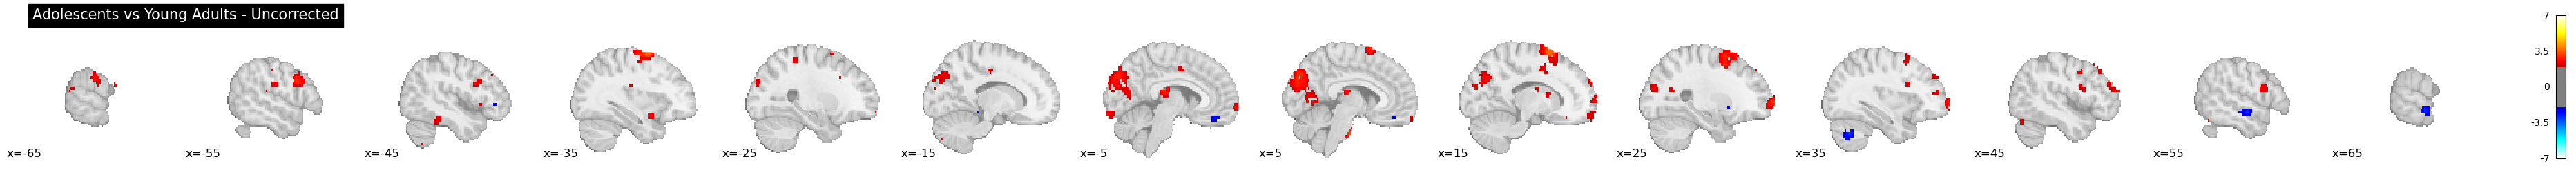

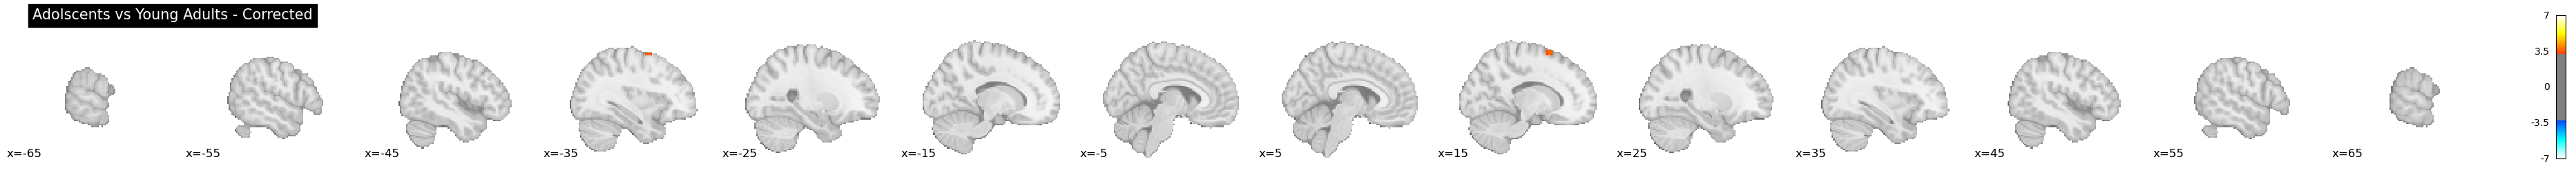

In [117]:
plot_stat_map(z_map, threshold=2, vmax=7,
              cut_coords=range(-65,66,10), display_mode='x', colorbar=True,
              title='Adolescents vs Young Adults - Uncorrected')
plot_stat_map(z_map_thresh, threshold=threshold, vmax=7,
              cut_coords=range(-65,66,10), display_mode='x', colorbar=True,
              title='Adolscents vs Young Adults - Corrected')

In [119]:
# Find PPI data
file_list = []
for subj in subjs_list:
    file_list.append(glob.glob(os.path.join(outp_dir+'/subject_results/'+subj+'_ppi_region08nuis-social.nii.gz'))[0])

# Create second level model
model = SecondLevelModel(mask_img=mni_gm_mask, smoothing_fwhm=8.0)
model.fit(file_list, design_matrix=design_matrix)
    
# Create group map
z_map = model.compute_contrast('group', output_type='z_score')
z_map.to_filename(os.path.join(outp_dir+'zmap_adoleVadult_ppi_region08-nuis-social_unc.nii.gz'))

# Multiple comparisons correction
z_map_thresh, threshold = threshold_stats_img(z_map, alpha=.001, height_control='fpr')
z_map_thresh.to_filename(os.path.join(data_dir,'group',
                                      'zmap_adoleVadult_ppi_region08-nuis-social_fdr05.nii.gz'))

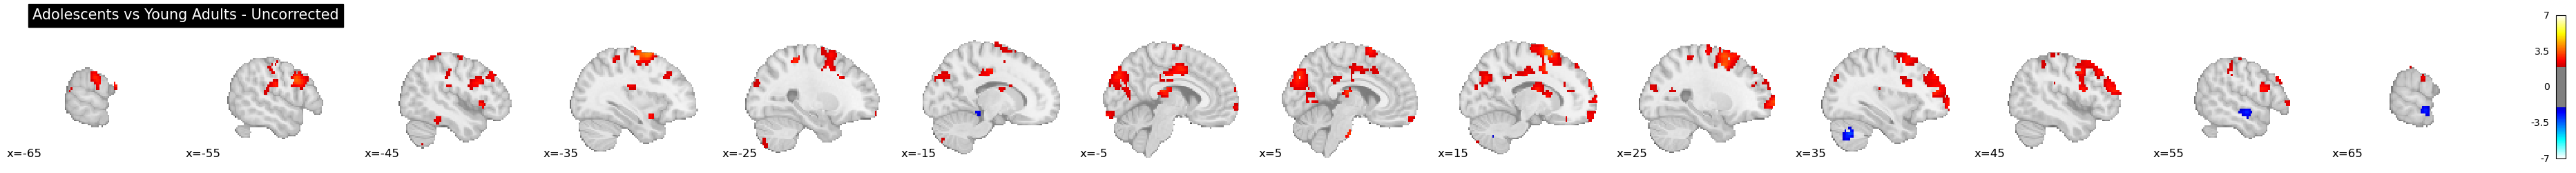

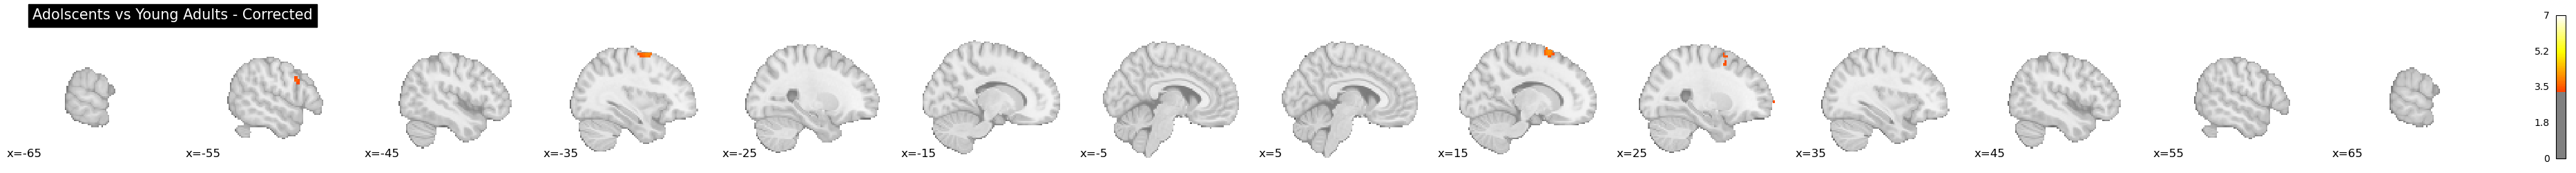

In [120]:
plot_stat_map(z_map, threshold=2, vmax=7,
              cut_coords=range(-65,66,10), display_mode='x', colorbar=True,
              title='Adolescents vs Young Adults - Uncorrected')
plot_stat_map(z_map_thresh, threshold=threshold, vmax=7,
              cut_coords=range(-65,66,10), display_mode='x', colorbar=True,
              title='Adolscents vs Young Adults - Corrected')